In [23]:
!nvidia-smi

Mon Apr  7 20:15:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:42:00.0 Off |                    0 |
| N/A   43C    P0             54W /  250W |   29433MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [21]:
!pip install --upgrade transformers accelerate datasets optimum peft auto-gptq bitsandbytes scikit-learn torch --quiet
!pip install flash-attn --no-build-isolation --quiet # for qwen2

In [22]:
import os
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, GPTQConfig, BitsAndBytesConfig
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import gc # garbage collector interface
import pprint
from typing import List, Tuple

# --- Configuration --- (flexible: MODEL_NAME, DATASET_CONFIG, BATCH_SIZE, MAX_SAMPLES, QUANTIZATION_MODE, OUTPUT_FILENAME)
MODEL_NAME = 'Qwen/Qwen2.5-7B-Instruct' # try different models later
DATASET_NAME = 'UTAustin-AIHealth/MedHallu'
DATASET_CONFIG = 'pqa_labeled' # try adding pqa_artiifcal later
BATCH_SIZE = 8
MAX_SAMPLES = 16 #1000 # switch back
QUANTIZATION_MODE = None #'8bit_bnb'
OUTPUT_FILENAME = f'hallucination_results_{MODEL_NAME}_{QUANTIZATION_MODE}_{DATASET_CONFIG}.csv'

# --- Load Dataset ---
print(f'Loading {DATASET_NAME} dataset ({DATASET_CONFIG})...')
ds = load_dataset(DATASET_NAME, DATASET_CONFIG)
dataset = ds['train'] # use train split which has 1k labelled samples

if MAX_SAMPLES is not None:
    print(f'Limiting dataset to {MAX_SAMPLES} samples for testing.')
    dataset = dataset.select(range(MAX_SAMPLES)) # for N rows, there are 2*N answers for hallucination-detection LLM to classify (1 gt, 1 hallucinated answers)

# --- Setup Model and Tokenizer
print(f'Loading tokenizer for {MODEL_NAME}...')
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True, padding_side="left") # was getting an error when trying to run inference on inputs with default padding_side = right
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # set pad token for batching if not present

print(f'Setting up {MODEL_NAME} with quantization: {QUANTIZATION_MODE}...')

quantization_config = None
if QUANTIZATION_MODE == '8bit_bnb':
    quantization_config = BitsAndBytesConfig(load_in_8bit=True)
elif QUANTIZATION_MODE == '4bit_bnb':
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )
elif QUANTIZATION_MODE == '4bit_gptq':
    quantization_config = GPTQConfig(bits=4, dataset='c4', tokenizer=tokenizer)
else:
    print("Loading uncompressed model")

model_kwargs = {
    "quantization_config": quantization_config,
    "device_map": "auto",
    "attn_implementation": "eager", #"flash_attention_2", ; doesn't work on Volta GPU (old) ; so ignoring this for now ; may revisit if I need to speed up inference
    "torch_dtype": torch.float16, # torch.bfloat16 for ampere, maybe not best on older Volta GPU
    "trust_remote_code": True
}

if QUANTIZATION_MODE == "none":
    model_kwargs.pop("quantization_config")
elif QUANTIZATION_MODE == "4bit_gptq":
    model_kwards.pop("torch_dtype")

try:
    if 'model' in globals():
        del model
    if 'classifier' in globals():
        del classifier
    gc.collect()
    torch.cuda.empty_cache()
    model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, **model_kwargs)
    print(f"{MODEL_NAME} model loaded successfully!")
    print(model.hf_device_map)
except Exception as e:
    print(f"Failed to load model: {e}")
    raise e

# --- Setup Pipeline ---
classifier = pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
)

# --- Define Prompting Function ---
# used in the paper
original_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question and an
answer, your objective is to determine if the provided answer contains non-factual or hallucinated information. You SHOULD give your judgement based
on the following hallucination types and the world knowledge.

You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual and '1' if the answer is hallucinated.
You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual and '1' if the answer is hallucinated. No letter or word, just the integer value.
"""

# modification on our part to allow model to refrain from making a classification if it is not sure
not_sure_system_prompt = """
You are an AI assistant with extensive knowledge in the field of medicine. I want you act as an answer judge. Given a question, an
answer, and relevant World Knowledge, determine if the provided answer is factual or contains hallucinated information based on the knowledge provided and established medical facts.

- If the answer is factual and consistent with world knowledge, return '0'.
- If the answer contains non-factual, hallucinated, or contradictory information based on the knowledge provided or established medical facts (e.g., Misinterpretation, Incomplete Info, Mechanism Misattribution, Fabrication), return '1'.
- If you are genuinely uncertain or cannot make a definitive judgement based on the provided context and your medical knowledge, return '2'.

Do not return anything else, just the integer value.

Return '0' for factual, '1' for hallucinated, '2' for not sure.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, '2' if not sure. No letter or word, just the integer value.
"""

not_sure_system_prompt2 = """
You are an AI judge with extensive knowledge in the field of medicine. I want you act as an answer judge. Given World Knowledge, a Question, and an Answer:
- Return '0' if the Answer is factual based on the Knowledge and your understanding of medicine.
- Return '1' if the Answer is hallucinated based on the Knowledge and/or your understanding of medicine.
- Return '2' if you are unsure.

You SHOULD give your judgement based on the following hallucination types and the world knowledge.
You are trying to determine if there is a factual contradiction between the answer and the world knowledge.
Some information in the answer might be fabricated. Answer '0' if the answer is factual, '1' if the answer is hallucinated, '2' if you are unsure.

Output only the single digit 0, 1, or 2 and nothing else.

You can categorize the answer as hallucinated if it falls in either of the category:

Type: Misinterpretation of #Question#: These are hallucinated answers that misunderstands the question, leading to an off-topic or
irrelevant response.
Type: Incomplete Information: These are hallucinated answers that Point out what is not true without providing correct information.
Type: Mechanism and Pathway Misattribution - These are hallucinated answer that falsely attribution of biological mechanisms,
molecular pathways, or disease processes that contradicts established medical knowledge
Type: Methodological and Evidence Fabrication - Inventing false research methods, statistical data, or specific clinical outcomes

Do not return anything else, just the answer.
Return just an integer value, '0' if the answer is factual, '1' if the answer is hallucinated, or '2'. No letter or word, just the integer value.
"""

def format_prompt_chatml(knowledge: str, question: str, answer: str) -> List[int]:
    few_shot_not_sure_user_content = f"""
    World Knowledge: [Example Knowledge Snippet]
    Question: [Example Question]
    Answer: [Example Factual Answer]
    Your Judgement: 0
    
    World Knowledge: [Example Knowledge Snippet 2]
    Question: [Example Question 2]
    Answer: [Example Hallucinated Answer]
    Your Judgement: 1
    
    World Knowledge: [Example Knowledge Snippet 3 - where answer might be ambiguous or knowledge insufficient]
    Question: [Example Question 3]
    Answer: [Example Ambiguous Answer or Answer unrelated to Knowledge]
    Your Judgement: 2
    
    --- Now your turn ---
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}
    
    Return just '0' (factual), '1' (hallucinated), or '2' (not sure).
    Your Judgement:"""

    original_user_content = f""""
    World Knowledge: {knowledge}
    Question: {question}
    Answer: {answer}

    Return just an integer value, '0' if the answer is factual, and '1' if the answer is hallucinated. No letter or word, just the integer value.
    
    Your Judgement:"""
    
    messages = [
        {"role": "system", "content": original_system_prompt.strip()}, # remove leading/trailing whitespaces with .strip()
        {"role": "user", "content": original_user_content.strip()} # original meaning, from the MedHallu paper
    ]
    return messages

# --- Inference and Evaluation ---
all_prompts = [] # all string prompts
all_ground_truths = [] # corresponding labels for each prompt (0: truth, 1: hallucinated)

print("Preparing prompts")
for i, row in enumerate(dataset):
    knowledge = row["Knowledge"]
    question = row["Question"]
    hallucinated_answer = row["Hallucinated Answer"]
    ground_truth_answer = row["Ground Truth"]

    # create prompts for hallucinated and ground truth answers
    prompt_hallucinated = format_prompt_chatml(knowledge, question, hallucinated_answer) # type: list of integers (tokens)
    prompt_truth = format_prompt_chatml(knowledge, question, ground_truth_answer)

    all_prompts.append(prompt_hallucinated)
    all_ground_truths.append(1)
    all_prompts.append(prompt_truth)
    all_ground_truths.append(0)

print("Prompts are prepared.")

Loading UTAustin-AIHealth/MedHallu dataset (pqa_labeled)...
Limiting dataset to 16 samples for testing.
Loading tokenizer for Qwen/Qwen2.5-7B-Instruct...
Setting up Qwen/Qwen2.5-7B-Instruct with quantization: None...
Loading uncompressed model


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


Qwen/Qwen2.5-7B-Instruct model loaded successfully!
{'': device(type='cuda', index=0)}
Preparing prompts
Prompts are prepared.


In [25]:
print(f"Starting batch inference on {len(all_prompts)} prompts...")
with torch.no_grad():
    outputs = classifier(
        all_prompts,
        max_new_tokens=1,
        batch_size=BATCH_SIZE,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=False,
        repetition_penalty=1.2
    )
print("Inference complete. Processing Results.")

Starting batch inference on 32 prompts...
Inference complete. Processing Results.


In [26]:
# -- Process Results -- 
predictions = []
raw_outputs = []

def parse_prediction(generated_text):
    """Extract the '0' or '1' from generated text, in case model does not listen to instructions and adds other tokens"""
    text = generated_text.strip()
    text_start = text[-10:]
    #print("text start: ", text_start)
    if '0' in text_start:
        return 0
    elif '1' in text_start:
        return 1
    elif '2' in text_start:
        return 2
    else:
        #print(f"Could not parse '0' or '1' from model output: {text}")
        return -1

#pprint.pp(outputs[0][0]['generated_text'][2])
# outputs[0] : list[dict]
# outputs[0][0]: dict
# outputs[0][0]['generated_text'] : list[dict] ; idx 0: system, idx 1: user, idx 2: assisstant
# outputs[0][0]['generated_text'][-1] : dict

# iterate through each output, process it, and append to lists for predictions and raw model outputs
for i, output in enumerate(outputs):
    full_chat = output[0]['generated_text'] # this INCLUDES the prompt ; we only want newly generated text
    assistant_response_dict = full_chat[-1]
    #print(assistant_response_dict)
    model_response = None
    if assistant_response_dict['role'] == 'assistant':
        model_response = assistant_response_dict['content']
    
    pred = parse_prediction(model_response)
    predictions.append(pred)
    raw_outputs.append(model_response) # store the raw '!!!!!' or '0' or '1'

{'role': 'assistant', 'content': '!'}
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '0'}
text start:  0
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '0'}
text start:  0
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role': 'assistant', 'content': '!'}
text start:  !
{'role':

In [49]:
!pip install matplotlib --quiet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Assemble final results ---
def filter_invalid_pairs(pairs: list[tuple[int, int]]):
    """filter out any results where the model did not produce a valid output (i.e. anything other than 0 or 1)"""
    valid_pairs = []
    for pair in pairs:
        if pair[1] == -1:
            pass
        else:
            valid_pairs.append(pair)
    return valid_pairs

raw_gt_pred_pairs = list(zip(all_ground_truths, predictions))
gt_pred_pairs = filter_invalid_pairs(raw_gt_pred_pairs)


# --- Calculate Metrics ---
accuracy = None
precision = None
recall = None
f1 = None
abstention_rate = None
cm = None

if len(gt_pred_pairs) > 0:
    TP = len([gt == pred for (gt,pred) in gt_pred_pairs if pred == 1])
    TN = len([gt == pred for (gt,pred) in gt_pred_pairs if pred == 0])
    FP = len([gt != pred for (gt,pred) in gt_pred_pairs if pred == 1]) # FIX THIS
    FN = len([gt != pred for (gt,pred) in gt_pred_pairs if pred == 0]) # FIX THIS
    total_valid_preds = len(gt_pred_pairs)
    invalid_count = len(raw_gt_pred_pairs) - len(gt_pred_pairs)
    abstention_rate = invalid_count / len(raw_gt_pred_pairs)
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    valid_gts = [gt for (gt,pred) in gt_pred_pairs]
    valid_preds = [pred for (gt,pred) in gt_pred_pairs]
    precision, recall, f1, support = precision_recall_fscore_support(
        valid_gts, valid_preds, average='binary', pos_label=1, zero_division=0
    )
    cm = confusion_matrix(valid_gts, valid_preds, labels=[0,1]) # unused at the moment
else:
    print("No valid predictions were made, skipping metric calculations.")


# --- Save Results ---
results_df = []
results_df.append({
    'Baseline': {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'abstention_rate': abstention_rate}
})
dp = ConfusionMatrixDisplay(cm)

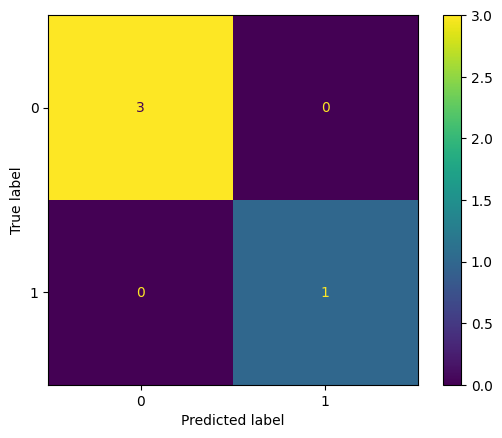

In [50]:
dp.plot()
plt.show()

In [43]:
gt_pred_pairs

[(0, 0), (0, 0), (0, 0), (1, 1)]

In [45]:
[gt != pred for (gt,pred) in gt_pred_pairs if pred == 0]

[False, False, False]

In [ ]:
tokenizer.encode('!')

## Tests

In [ ]:
def check_dataset():
  print(ds['train'])
  i = 0
  for row in ds['train']:
    if i == 4:
      break
    question = row['Question']
    hallucinated_answer = row['Hallucinated Answer']
    ground_truth_answer = row['Ground Truth']
    print(ground_truth_answer)
    i += 1
check_dataset()